In [1]:
import sys
sys.executable

'/home/nithin/data2/nithin/anaconda3/bin/python'

In [2]:
import pandas as pd
import os

In [3]:
df = pd.read_csv('Train_ULAK.csv').dropna()
df

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,80,68855579,10,6,1038,11595,346,0,103.800000,167.133879,...,32,998.0000,0.0000,998,998,6.830000e+07,0.0000,68300000,68300000,DoS Hulk
1,53,196,2,2,70,174,35,35,35.000000,0.000000,...,32,0.0000,0.0000,0,0,0.000000e+00,0.0000,0,0,BENIGN
2,123,118,2,2,96,96,48,48,48.000000,0.000000,...,20,0.0000,0.0000,0,0,0.000000e+00,0.0000,0,0,BENIGN
3,80,295657,7,10,1114,15841,1084,0,159.142857,407.829796,...,20,0.0000,0.0000,0,0,0.000000e+00,0.0000,0,0,BENIGN
4,80,15705351,7,5,407,452,377,0,58.142857,140.620563,...,20,360718.0000,0.0000,360718,360718,9.767208e+06,0.0000,9767208,9767208,BENIGN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1783351,41272,98689782,8,5,11595,327,5792,0,1449.375000,2046.673464,...,32,13859.0000,0.0000,13859,13859,9.860000e+07,0.0000,98600000,98600000,BENIGN
1783352,443,90956783,63,77,1041,135313,373,0,16.523810,68.018939,...,32,198255.7778,362537.3486,1165022,77291,9.908053e+06,290822.6482,10000000,9132848,BENIGN
1783353,443,1241813,3,3,0,0,0,0,0.000000,0.000000,...,28,0.0000,0.0000,0,0,0.000000e+00,0.0000,0,0,BENIGN
1783354,53,71509,2,2,78,330,39,39,39.000000,0.000000,...,32,0.0000,0.0000,0,0,0.000000e+00,0.0000,0,0,BENIGN


In [4]:
!pip install scikit-learn

In [5]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.impute import SimpleImputer
import torch

my_imputer = SimpleImputer(strategy='mean')

def cleanNums(df):
    # Replace inf and -inf with NaN
    df.loc[:, :] = df.replace([np.inf, -np.inf], np.nan)
    
    # Impute NaN values for numeric columns
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    my_imputer.fit(df[numeric_cols])
    df.loc[:,numeric_cols] = my_imputer.transform(df[numeric_cols])
    
    # Check if all NaNs are filled
    if df.isnull().sum().sum() > 0:
        raise ValueError("DataFrame still contains NaN values after imputation.")

    return df

class RandomForestWrapper:
    def __init__(self, label_col, feature_cols=None, n_estimators=10, random_state=42, make_binary_on=None):
        self.label_col = label_col
        self.feature_cols = feature_cols
        self.n_estimators = n_estimators
        self.random_state = random_state
        self.model = RandomForestClassifier(n_estimators=self.n_estimators, random_state=self.random_state)
        self.make_binary_on = make_binary_on
        self.fitted = False

    @property
    def is_fitted(self):
        return self.fitted

    
    def preprocess(self, df):
        df = cleanNums(df)
        
        # Extract feature and label data
        X = df.drop(columns=[self.label_col])
        y = df[self.label_col]
        
        # If feature_cols is specified, use only those columns
        if self.feature_cols:
            X = X[self.feature_cols]

        # If there is a label column on which to turn this binary
        if self.make_binary_on:
            print("Making binary on:", self.make_binary_on)
            y = df[' Label'] == self.make_binary_on
                
        return X, y

    def train(self, train_df):
        X_train, y_train = self.preprocess(train_df)
        print("X:", X_train.shape, ",Y:", y_train.shape)
        self.model.fit(X_train, y_train)
        self.fitted = True

    def predict(self, X):
        return self.model.predict(X[self.feature_cols])
    
    def test(self, test_df):
        X_test, y_test = self.preprocess(test_df)
        y_pred = self.model.predict(X_test)
        
        accuracy = accuracy_score(y_test, y_pred)
        
        return accuracy

In [6]:
class SpecializedRandomForestManager:
    def __init__(self):
        self.label_col = ' Label'
        # Create individual random forest classifiers for each label
        self.classifiers = {}
        
        # Define the feature columns for each attack category
        self.category_columns = {
            'BENIGN':[' Flow Duration', ' Fwd IAT Max'],
            'DoS Hulk':[' Fwd Packet Length Max', ' Flow Packets/s'],
            'DDoS':[' Flow Packets/s', ' Total Fwd Packets'],
            'PortScan': [' Destination Port', ' Fwd IAT Max'],
            'DoS GoldenEye': ['Fwd Packets/s', 'Bwd Packet Length Max'],
            'FTP-Patator': [' Fwd Packet Length Mean'],
            'DoS slowloris': [' Fwd IAT Max', ' Fwd IAT Mean'],
            'DoS Slowhttptest': [' Destination Port', ' Fwd IAT Mean'],
            'SSH-Patator': [' Fwd Packet Length Mean', ' Flow Packets/s'],
            'Web Attack � XSS': [' Fwd Packet Length Max'],
            'Web Attack � Brute Force': [' Fwd Packet Length Mean'],
            'Web Attack � Sql Injection': [' Fwd Packet Length Std']
        }

        self.category_order = ['Web Attack � Sql Injection','Web Attack � XSS', 'DoS slowloris','DoS GoldenEye', 'DoS Slowhttptest',
                               'Web Attack � Brute Force','PortScan','SSH-Patator','FTP-Patator','DoS Hulk','DDoS','BENIGN']
        
        # Initialize specialized classifiers
        for category, feature_cols in self.category_columns.items():
            self.classifiers[category] = RandomForestWrapper(label_col=self.label_col, feature_cols=feature_cols, make_binary_on=category)
        # final clasifier to take the other classifiers and pick the best label
        self.final_classifier = RandomForestWrapper(label_col=self.label_col, feature_cols=self.category_order)

    def preprocess(self, df):
        df = cleanNums(df)
        
        # Extract feature and label data
        X = df.drop(columns=[self.label_col])
        y = df[self.label_col]

        return X, y
    
    def filter_df(self, df, label):
        if label in ['BENIGN', 'Web Attack � Brute Force', 'Web Attack � Sql Injection', 'Web Attack � XSS']:
            return df[df[' Destination Port'].isin([80, 443])]
        elif label == 'SSH-Patator':
            return df[df[' Destination Port'] == 22]
        elif label == 'FTP-Patator':
            return df[df[' Destination Port'] == 21]

        return df
    
    def filter_pred(self, df, label):
        if label in ['BENIGN', 'Web Attack � Brute Force', 'Web Attack � Sql Injection', 'Web Attack � XSS']:
            return df[' Destination Port'] in [80, 443]
        elif label == 'SSH-Patator':
            return df[' Destination Port'] == 22
        elif label == 'FTP-Patator':
            return df[' Destination Port'] == 21

        return True
        
    def train(self, df):
        X, y = self.preprocess(df)
        cols = []
        for label in self.category_order:
            clf = self.classifiers[label]
            # Pre-filter the DataFrame based on the label and destination port conditions
            filtered_df = self.filter_df(df, label)

            print("Label:", label)
            # If the DataFrame is empty after filtering, skip this iteration
            if filtered_df.empty:
                continue
            print("filtered_df.shape", filtered_df.shape)
            
            # Train the classifier on the filtered DataFrame
            clf.train(filtered_df)

            # for use for the final classifier
            y_pred = clf.predict(X)
            cols.append(pd.Series(y_pred, name=label))

        # train the final classifier
        X_fin = pd.concat(cols,axis=1)
        print("Feed of final classifier",X_fin)
        self.final_classifier.model.fit(X_fin, y)
        
            
    def predict(self, X):
        accuracies = {}
        cols = []
        for label in self.category_order:
            clf = self.classifiers[label]
            if clf.is_fitted  : # skip the rest if this model had no data to train
                # Pre-filter the DataFrame based on the label and destination port conditions
                filtered_df = self.filter_df(X, label)
    
                print("Label:", label)
                # If the DataFrame is empty after filtering, skip this iteration
                if filtered_df.empty:
                    continue
    
                print("filtered_df.shape", filtered_df.shape)
    
                # for use for the final classifier
                y_pred = clf.predict(X)
                cols.append(pd.Series(y_pred, name=label))

        # train the final classifier
        X_fin = pd.concat(cols,axis=1)
        print("Feed of final classifier",X_fin)
        y_pred = self.final_classifier.model.predict(X_fin)

        return y_pred
            
    
    def test(self, df):
        X, y = self.preprocess(df)
        accuracies = {}
        cols = []
        for label in self.category_order:
            clf = self.classifiers[label]
            if clf.is_fitted  : # skip the rest if this model had no data to train
                # Pre-filter the DataFrame based on the label and destination port conditions
                filtered_df = self.filter_df(df, label)
    
                print("Label:", label)
                # If the DataFrame is empty after filtering, skip this iteration
                if filtered_df.empty:
                    continue
    
                print("filtered_df.shape", filtered_df.shape)
    
                # Test the classifier on the filtered DataFrame
                accuracies[label] = clf.test(filtered_df)
    
                # for use for the final classifier
                y_pred = clf.predict(X)
                cols.append(pd.Series(y_pred, name=label))

        # train the final classifier
        X_fin = pd.concat(cols,axis=1)
        print("Feed of final classifier",X_fin)
        y_pred = self.final_classifier.model.predict(X_fin)
        accuracies["Final"] = accuracy_score(y,y_pred)

        return accuracies



In [7]:
train_df = df
test_df = pd.read_csv('Test_ULAK.csv').dropna()
train_df, test_df

(          Destination Port   Flow Duration   Total Fwd Packets  \
 0                       80        68855579                  10   
 1                       53             196                   2   
 2                      123             118                   2   
 3                       80          295657                   7   
 4                       80        15705351                   7   
 ...                    ...             ...                 ...   
 1783351              41272        98689782                   8   
 1783352                443        90956783                  63   
 1783353                443         1241813                   3   
 1783354                 53           71509                   2   
 1783355               4306            2167                   2   
 
           Total Backward Packets  Total Length of Fwd Packets  \
 0                              6                         1038   
 1                              2                           70

In [8]:
# Initialize the manager class
manager = SpecializedRandomForestManager()

# Train the specialized classifiers
manager.train(train_df)

# Test the specialized classifiers
accuracies = manager.test(test_df)

# Print the accuracies
for label, acc in accuracies.items():
    print(f"Accuracy for {label}: {acc}")


Label: Web Attack � Sql Injection
filtered_df.shape (708159, 79)
Making binary on: Web Attack � Sql Injection
X: (708159, 1) ,Y: (708159,)
Label: Web Attack � XSS
filtered_df.shape (708159, 79)
Making binary on: Web Attack � XSS
X: (708159, 1) ,Y: (708159,)
Label: DoS slowloris
filtered_df.shape (1782497, 79)
Making binary on: DoS slowloris
X: (1782497, 2) ,Y: (1782497,)
Label: DoS GoldenEye
filtered_df.shape (1782497, 79)
Making binary on: DoS GoldenEye
X: (1782497, 2) ,Y: (1782497,)
Label: DoS Slowhttptest
filtered_df.shape (1782497, 79)
Making binary on: DoS Slowhttptest
X: (1782497, 2) ,Y: (1782497,)
Label: Web Attack � Brute Force
filtered_df.shape (708159, 79)
Making binary on: Web Attack � Brute Force
X: (708159, 1) ,Y: (708159,)
Label: PortScan
filtered_df.shape (1782497, 79)
Making binary on: PortScan
X: (1782497, 2) ,Y: (1782497,)
Label: SSH-Patator
filtered_df.shape (10661, 79)
Making binary on: SSH-Patator
X: (10661, 2) ,Y: (10661,)
Label: FTP-Patator
filtered_df.shape (853

In [9]:
score_rank = sorted( ((v,k) for k,v in accuracies.items()), reverse=True)
score_rank

[(0.9999753683660852, 'Web Attack � Sql Injection'),
 (0.9994236197663936, 'Web Attack � XSS'),
 (0.9993181303094009, 'DoS slowloris'),
 (0.9991325210813008, 'DoS GoldenEye'),
 (0.9988531303484764, 'DoS Slowhttptest'),
 (0.9987142287096472, 'Web Attack � Brute Force'),
 (0.998054033776972, 'PortScan'),
 (0.9858338699291693, 'SSH-Patator'),
 (0.980729807298073, 'FTP-Patator'),
 (0.9780766194893598, 'DoS Hulk'),
 (0.9705233007963613, 'DDoS'),
 (0.9546898567487515, 'Final'),
 (0.9532787167903995, 'BENIGN')]

In [10]:
[r[1] for r in score_rank]

['Web Attack � Sql Injection',
 'Web Attack � XSS',
 'DoS slowloris',
 'DoS GoldenEye',
 'DoS Slowhttptest',
 'Web Attack � Brute Force',
 'PortScan',
 'SSH-Patator',
 'FTP-Patator',
 'DoS Hulk',
 'DDoS',
 'Final',
 'BENIGN']

## Create a single classifier out of the managed classifiers in the Random Forest Classifier Manager

In [14]:
import numpy as np
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.utils.multiclass import unique_labels

class SpecialClassifierRoutedRandomForest(BaseEstimator, ClassifierMixin):
    def __init__(self,label_col=' Label'):
        self.manager = SpecializedRandomForestManager()
        self.label_col=label_col
        
    def fit(self, X, y):
        # Check that X and y have correct shape
        Xc, yc = check_X_y(X, y)
        # Store the classes seen during fit
        self.classes_ = unique_labels(y)
        self.X_ = X
        self.y_ = y
        print("Fit:", X.shape,"->",y.shape)
        # train all the clasifiers being managed by the manager
        self.manager.train(pd.concat([X, y], axis=1))
        
        return self
        
    def predict(self, X):
        # Check if fit has been called
        check_is_fitted(self)
        # Input validation
        X_check = check_array(X)
        print("Predict:", X.shape)
        return self.manager.predict(X)
        
    def train(self,df):
        cdf = cleanNums(df)
        X = cdf.drop(columns=[self.label_col])
        y = cdf[self.label_col]
        self.fit(X,y)
        return self
        
    def test(self,test_df):
        X_test = cleanNums(test_df.drop(columns=[self.label_col]))
        y_test = test_df[self.label_col]
        y_pred = self.predict(X_test)
        return y_test, y_pred
        

In [15]:
clf = SpecialClassifierRoutedRandomForest()

In [37]:
label_col = ' Label'
# Extract feature and label data
X = cleanNums(df.drop(columns=[label_col]))
y = df[label_col]
print(type(X), type(y))
clf.fit(X,y)

<class 'pandas.core.frame.DataFrame'> <class 'pandas.core.series.Series'>
Fit: (1782497, 78) -> (1782497,)
Label: Web Attack � Sql Injection
filtered_df.shape (708159, 79)
Making binary on: Web Attack � Sql Injection
X: (708159, 1) ,Y: (708159,)
Label: Web Attack � XSS
filtered_df.shape (708159, 79)
Making binary on: Web Attack � XSS
X: (708159, 1) ,Y: (708159,)
Label: DoS slowloris
filtered_df.shape (1782497, 79)
Making binary on: DoS slowloris
X: (1782497, 2) ,Y: (1782497,)
Label: DoS GoldenEye
filtered_df.shape (1782497, 79)
Making binary on: DoS GoldenEye
X: (1782497, 2) ,Y: (1782497,)
Label: DoS Slowhttptest
filtered_df.shape (1782497, 79)
Making binary on: DoS Slowhttptest
X: (1782497, 2) ,Y: (1782497,)
Label: Web Attack � Brute Force
filtered_df.shape (708159, 79)
Making binary on: Web Attack � Brute Force
X: (708159, 1) ,Y: (708159,)
Label: PortScan
filtered_df.shape (1782497, 79)
Making binary on: PortScan
X: (1782497, 2) ,Y: (1782497,)
Label: SSH-Patator
filtered_df.shape (10

SpecialClassifierRoutedRandomForest()

In [38]:
# Extract feature and label data
X_test = cleanNums(test_df.drop(columns=[label_col]))
y_test = test_df[label_col]
y_pred = clf.predict(X_test)
y_test, y_pred
accuracy_score(y_test, y_pred)

Predict: (511828, 78)
Label: Web Attack � Sql Injection
filtered_df.shape (202991, 78)
Label: Web Attack � XSS
filtered_df.shape (202991, 78)
Label: DoS slowloris
filtered_df.shape (511828, 78)
Label: DoS GoldenEye
filtered_df.shape (511828, 78)
Label: DoS Slowhttptest
filtered_df.shape (511828, 78)
Label: Web Attack � Brute Force
filtered_df.shape (202991, 78)
Label: PortScan
filtered_df.shape (511828, 78)
Label: SSH-Patator
filtered_df.shape (3106, 78)
Label: FTP-Patator
filtered_df.shape (2439, 78)
Label: DoS Hulk
filtered_df.shape (511828, 78)
Label: DDoS
filtered_df.shape (511828, 78)
Label: BENIGN
filtered_df.shape (202991, 78)
Feed of final classifier         Web Attack � Sql Injection  Web Attack � XSS  DoS slowloris  \
0                            False             False          False   
1                            False             False          False   
2                            False             False          False   
3                            False             Fa

0.9546898567487515

In [18]:
clf.train(df)
res = clf.test(test_df)
res

Fit: (1782497, 78) -> (1782497,)
Label: Web Attack � Sql Injection
filtered_df.shape (708159, 79)
Making binary on: Web Attack � Sql Injection
X: (708159, 1) ,Y: (708159,)
Label: Web Attack � XSS
filtered_df.shape (708159, 79)
Making binary on: Web Attack � XSS
X: (708159, 1) ,Y: (708159,)
Label: DoS slowloris
filtered_df.shape (1782497, 79)
Making binary on: DoS slowloris
X: (1782497, 2) ,Y: (1782497,)
Label: DoS GoldenEye
filtered_df.shape (1782497, 79)
Making binary on: DoS GoldenEye
X: (1782497, 2) ,Y: (1782497,)
Label: DoS Slowhttptest
filtered_df.shape (1782497, 79)
Making binary on: DoS Slowhttptest
X: (1782497, 2) ,Y: (1782497,)
Label: Web Attack � Brute Force
filtered_df.shape (708159, 79)
Making binary on: Web Attack � Brute Force
X: (708159, 1) ,Y: (708159,)
Label: PortScan
filtered_df.shape (1782497, 79)
Making binary on: PortScan
X: (1782497, 2) ,Y: (1782497,)
Label: SSH-Patator
filtered_df.shape (10661, 79)
Making binary on: SSH-Patator
X: (10661, 2) ,Y: (10661,)
Label: F

(0                 DoS Hulk
 1         DoS Slowhttptest
 2                   BENIGN
 3                 DoS Hulk
 4                 PortScan
                 ...       
 512072            DoS Hulk
 512073              BENIGN
 512074            DoS Hulk
 512075            DoS Hulk
 512076              BENIGN
 Name:  Label, Length: 511828, dtype: object,
 array(['DoS Hulk', 'DoS Slowhttptest', 'BENIGN', ..., 'DoS Hulk',
        'DoS Hulk', 'BENIGN'], dtype=object))

In [19]:
accuracy_score(*res)

0.9546898567487515

In [21]:
from sklearn.metrics import *

In [47]:
lbls = clf.manager.category_order
cm = confusion_matrix(*res, labels=lbls)

In [48]:
cm

array([[     0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      4],
       [     0,      0,      0,      0,      0,      0,      1,      0,
             0,      0,      0,    116],
       [     0,      0,    751,      1,      5,      0,      0,      0,
             0,      0,      1,    290],
       [     0,      0,      4,   1590,      5,      0,      1,      0,
             0,      6,      9,    246],
       [     0,      0,     13,      3,    656,      0,      0,      0,
             0,      4,      0,    318],
       [     0,      0,      0,      0,      0,     15,      0,      0,
             0,      0,      2,    255],
       [     0,      0,      0,      0,      0,      0,  28487,      0,
             0,      4,      2,    258],
       [     0,      0,      0,      0,      0,      0,      4,      0,
             0,      0,      0,   1063],
       [     0,      0,      0,      0,      0,      0,      0,      0,
             0,      0, 

In [51]:
import matplotlib.pyplot as plt
import numpy as np

def show_heatmap(matrix, title='Confusion Matrix', x_ticks=None, y_ticks=None):
    plt.figure(figsize=(8, 6))
    
    # Display the heatmap
    cax = plt.matshow(matrix, cmap='coolwarm')
    
    # Add a color legend
    plt.colorbar(cax)
    
    # Label x-axis ticks
    if x_ticks is not None:
        plt.xticks(range(len(x_ticks)), x_ticks)
        
    # Label y-axis ticks
    if y_ticks is not None:
        plt.yticks(range(len(y_ticks)), y_ticks)
    
    plt.title(title)
    
    plt.show()

<Figure size 800x600 with 0 Axes>

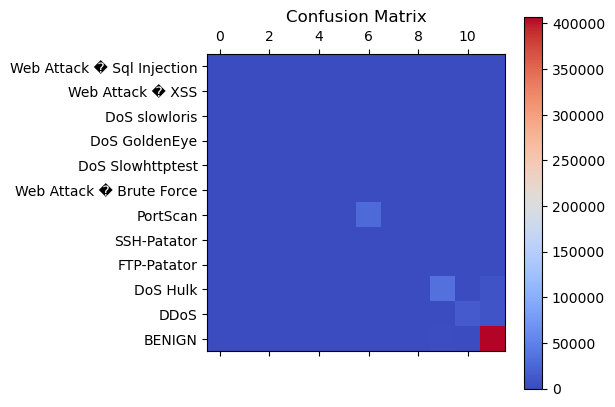

In [53]:
# Display the heatmap
show_heatmap(cm, title='Confusion Matrix', x_ticks=None, y_ticks=lbls)

In [75]:
precision_score(*res, average='weighted')

/home/nithin/data2/nithin/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.9489605384608767

In [34]:
recall_score(*res, average='weighted')

0.9546898567487515

In [57]:
pos_lbl=lbls[:-1]

In [58]:
precision_score(*res, average='weighted',labels=pos_lbl)

/home/nithin/data2/nithin/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.9277264555164679

In [59]:
recall_score(*res, average='weighted',labels=pos_lbl)

0.8084934619677883

In [76]:
def show_metrics(res):
    print("Accuracy:", accuracy_score(*res))
    print("Precision:", precision_score(*res, average='weighted'))
    print("Recall:", recall_score(*res, average='weighted'))
    cm = confusion_matrix(*res, labels=lbls)
    show_heatmap(cm, title='Confusion Matrix', x_ticks=None, y_ticks=lbls)

Accuracy: 0.9546898567487515


/home/nithin/data2/nithin/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Precision: 0.9489605384608767
Recall: 0.9546898567487515


<Figure size 800x600 with 0 Axes>

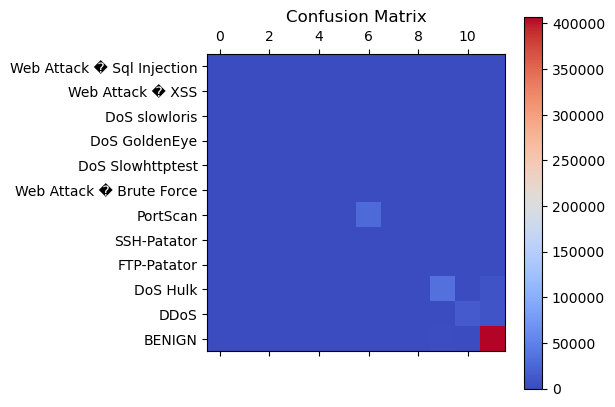

In [77]:
show_metrics(res)

In [100]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
import numpy as np

def cross_validate(model, df, n_splits=5):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=1)

    for train_index, test_index in kf.split(df):
        df_train, df_test = df.loc[train_index], df.loc[test_index]

        model.train(df_train)
        res = model.test(df_test)
        
        show_metrics(res)
 

In [101]:
tot_df = pd.concat([df,test_df]).reset_index()

Fit: (1835460, 79) -> (1835460,)
Label: Web Attack � Sql Injection
filtered_df.shape (728730, 80)
Making binary on: Web Attack � Sql Injection
X: (728730, 1) ,Y: (728730,)
Label: Web Attack � XSS
filtered_df.shape (728730, 80)
Making binary on: Web Attack � XSS
X: (728730, 1) ,Y: (728730,)
Label: DoS slowloris
filtered_df.shape (1835460, 80)
Making binary on: DoS slowloris
X: (1835460, 2) ,Y: (1835460,)
Label: DoS GoldenEye
filtered_df.shape (1835460, 80)
Making binary on: DoS GoldenEye
X: (1835460, 2) ,Y: (1835460,)
Label: DoS Slowhttptest
filtered_df.shape (1835460, 80)
Making binary on: DoS Slowhttptest
X: (1835460, 2) ,Y: (1835460,)
Label: Web Attack � Brute Force
filtered_df.shape (728730, 80)
Making binary on: Web Attack � Brute Force
X: (728730, 1) ,Y: (728730,)
Label: PortScan
filtered_df.shape (1835460, 80)
Making binary on: PortScan
X: (1835460, 2) ,Y: (1835460,)
Label: SSH-Patator
filtered_df.shape (11074, 80)
Making binary on: SSH-Patator
X: (11074, 2) ,Y: (11074,)
Label: F

/home/nithin/data2/nithin/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Precision: 0.9500610686747366
Recall: 0.9557647674152528


<Figure size 800x600 with 0 Axes>

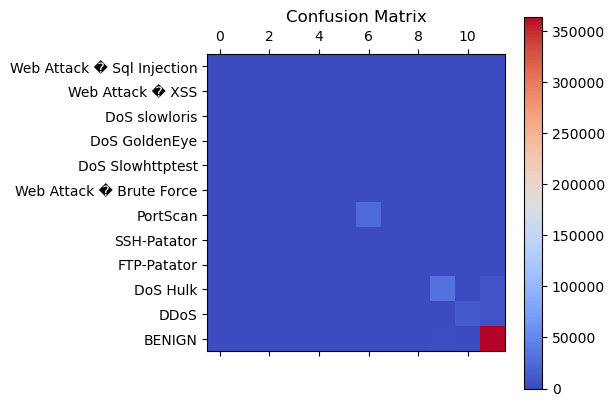

Fit: (1835460, 79) -> (1835460,)
Label: Web Attack � Sql Injection
filtered_df.shape (729564, 80)
Making binary on: Web Attack � Sql Injection
X: (729564, 1) ,Y: (729564,)
Label: Web Attack � XSS
filtered_df.shape (729564, 80)
Making binary on: Web Attack � XSS
X: (729564, 1) ,Y: (729564,)
Label: DoS slowloris
filtered_df.shape (1835460, 80)
Making binary on: DoS slowloris
X: (1835460, 2) ,Y: (1835460,)
Label: DoS GoldenEye
filtered_df.shape (1835460, 80)
Making binary on: DoS GoldenEye
X: (1835460, 2) ,Y: (1835460,)
Label: DoS Slowhttptest
filtered_df.shape (1835460, 80)
Making binary on: DoS Slowhttptest
X: (1835460, 2) ,Y: (1835460,)
Label: Web Attack � Brute Force
filtered_df.shape (729564, 80)
Making binary on: Web Attack � Brute Force
X: (729564, 1) ,Y: (729564,)
Label: PortScan
filtered_df.shape (1835460, 80)
Making binary on: PortScan
X: (1835460, 2) ,Y: (1835460,)
Label: SSH-Patator
filtered_df.shape (10970, 80)
Making binary on: SSH-Patator
X: (10970, 2) ,Y: (10970,)
Label: F

/home/nithin/data2/nithin/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Precision: 0.9485367641036972
Recall: 0.9544680897431707


<Figure size 800x600 with 0 Axes>

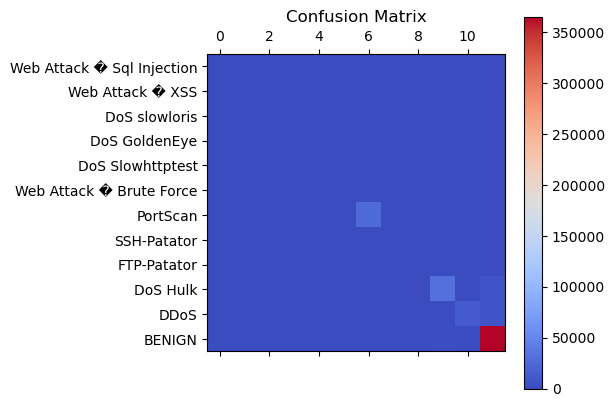

Fit: (1835460, 79) -> (1835460,)
Label: Web Attack � Sql Injection
filtered_df.shape (728666, 80)
Making binary on: Web Attack � Sql Injection
X: (728666, 1) ,Y: (728666,)
Label: Web Attack � XSS
filtered_df.shape (728666, 80)
Making binary on: Web Attack � XSS
X: (728666, 1) ,Y: (728666,)
Label: DoS slowloris
filtered_df.shape (1835460, 80)
Making binary on: DoS slowloris
X: (1835460, 2) ,Y: (1835460,)
Label: DoS GoldenEye
filtered_df.shape (1835460, 80)
Making binary on: DoS GoldenEye
X: (1835460, 2) ,Y: (1835460,)
Label: DoS Slowhttptest
filtered_df.shape (1835460, 80)
Making binary on: DoS Slowhttptest
X: (1835460, 2) ,Y: (1835460,)
Label: Web Attack � Brute Force
filtered_df.shape (728666, 80)
Making binary on: Web Attack � Brute Force
X: (728666, 1) ,Y: (728666,)
Label: PortScan
filtered_df.shape (1835460, 80)
Making binary on: PortScan
X: (1835460, 2) ,Y: (1835460,)
Label: SSH-Patator
filtered_df.shape (11012, 80)
Making binary on: SSH-Patator
X: (11012, 2) ,Y: (11012,)
Label: F

/home/nithin/data2/nithin/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Precision: 0.9516964042587313
Recall: 0.9545944885750711


<Figure size 800x600 with 0 Axes>

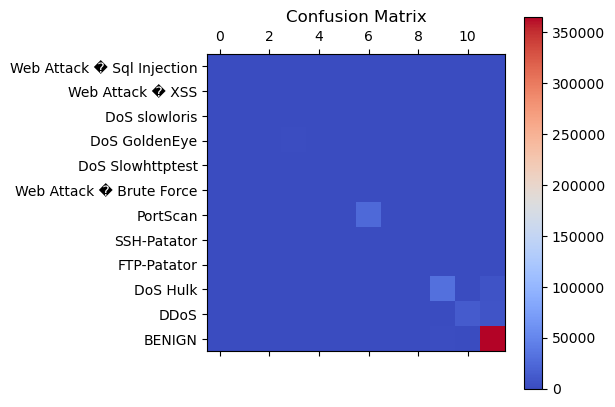

Fit: (1835460, 79) -> (1835460,)
Label: Web Attack � Sql Injection
filtered_df.shape (728688, 80)
Making binary on: Web Attack � Sql Injection
X: (728688, 1) ,Y: (728688,)
Label: Web Attack � XSS
filtered_df.shape (728688, 80)
Making binary on: Web Attack � XSS
X: (728688, 1) ,Y: (728688,)
Label: DoS slowloris
filtered_df.shape (1835460, 80)
Making binary on: DoS slowloris
X: (1835460, 2) ,Y: (1835460,)
Label: DoS GoldenEye
filtered_df.shape (1835460, 80)
Making binary on: DoS GoldenEye
X: (1835460, 2) ,Y: (1835460,)
Label: DoS Slowhttptest
filtered_df.shape (1835460, 80)
Making binary on: DoS Slowhttptest
X: (1835460, 2) ,Y: (1835460,)
Label: Web Attack � Brute Force
filtered_df.shape (728688, 80)
Making binary on: Web Attack � Brute Force
X: (728688, 1) ,Y: (728688,)
Label: PortScan
filtered_df.shape (1835460, 80)
Making binary on: PortScan
X: (1835460, 2) ,Y: (1835460,)
Label: SSH-Patator
filtered_df.shape (11000, 80)
Making binary on: SSH-Patator
X: (11000, 2) ,Y: (11000,)
Label: F

/home/nithin/data2/nithin/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Precision: 0.949254433534699
Recall: 0.9549235613960533


<Figure size 800x600 with 0 Axes>

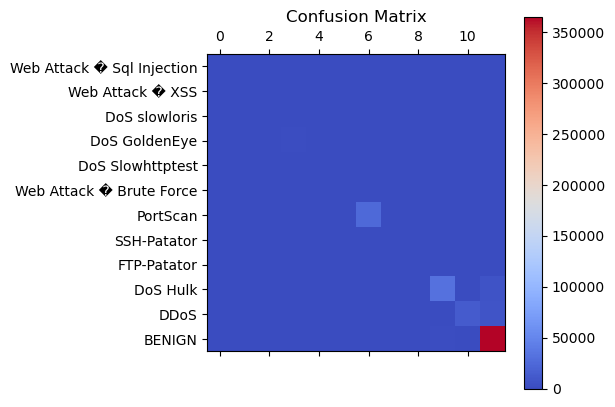

Fit: (1835460, 79) -> (1835460,)
Label: Web Attack � Sql Injection
filtered_df.shape (728952, 80)
Making binary on: Web Attack � Sql Injection
X: (728952, 1) ,Y: (728952,)
Label: Web Attack � XSS
filtered_df.shape (728952, 80)
Making binary on: Web Attack � XSS
X: (728952, 1) ,Y: (728952,)
Label: DoS slowloris
filtered_df.shape (1835460, 80)
Making binary on: DoS slowloris
X: (1835460, 2) ,Y: (1835460,)
Label: DoS GoldenEye
filtered_df.shape (1835460, 80)
Making binary on: DoS GoldenEye
X: (1835460, 2) ,Y: (1835460,)
Label: DoS Slowhttptest
filtered_df.shape (1835460, 80)
Making binary on: DoS Slowhttptest
X: (1835460, 2) ,Y: (1835460,)
Label: Web Attack � Brute Force
filtered_df.shape (728952, 80)
Making binary on: Web Attack � Brute Force
X: (728952, 1) ,Y: (728952,)
Label: PortScan
filtered_df.shape (1835460, 80)
Making binary on: PortScan
X: (1835460, 2) ,Y: (1835460,)
Label: SSH-Patator
filtered_df.shape (11012, 80)
Making binary on: SSH-Patator
X: (11012, 2) ,Y: (11012,)
Label: F

/home/nithin/data2/nithin/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Precision: 0.9524073346479061
Recall: 0.9552940407309339


<Figure size 800x600 with 0 Axes>

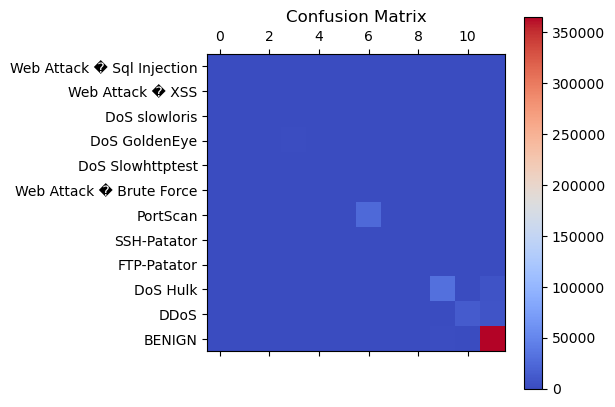

In [102]:
cross_validate(clf, tot_df, n_splits=5)

In [103]:
clf2 = RandomForestClassifier(n_estimators=150)

In [104]:
ctrain_df=cleanNums(train_df)
ctest_df=cleanNums(train_df)

In [105]:
def preprocess(df, label_col):
    df = cleanNums(df)
        
    # Extract feature and label data
    X = df.drop(columns=[label_col])
    y = df[label_col]

    return X, y

In [107]:
split_train = preprocess(ctrain_df, " Label")
split_test = preprocess(ctest_df, " Label")

In [108]:
clf2.fit(*split_train)

RandomForestClassifier(n_estimators=150)

In [111]:
y_pred = clf2.predict(split_test[0])

Accuracy: 0.9997750346844904
Precision: 0.9997754745331617
Recall: 0.9997750346844904


<Figure size 800x600 with 0 Axes>

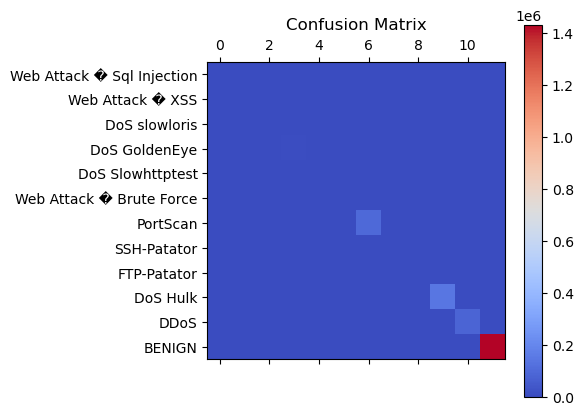

In [113]:
show_metrics((split_test[1],y_pred))

In [115]:
!pip install xgboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.3/200.3 MB 2.3 MB/s eta 0:00:00m eta 0:00:010:00:01


In [116]:
import xgboost as xgb

In [125]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y_train_enc = label_encoder.fit_transform(split_train[1])
y_test_enc = label_encoder.transform(split_test[1])

In [126]:
clf3 = xgb.XGBClassifier(objective='multi:softprob',eval_metric='mlogloss', n_estimators=150)


In [127]:
clf3.fit(split_train[0],y_train_enc)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=150, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob',
              predictor=None, ...)

In [131]:
y_pred = clf3.predict(split_test[0])

In [132]:
y_pred

array([4, 0, 0, ..., 0, 0, 0])

In [134]:
y_pred = label_encoder.inverse_transform(y_pred)
y_pred

array(['DoS Hulk', 'BENIGN', 'BENIGN', ..., 'BENIGN', 'BENIGN', 'BENIGN'],
      dtype=object)

In [ ]:
show_metrics((split_test[1],y_pred))

Accuracy: 0.9995590455411706
Precision: 0.9995613159328368
Recall: 0.9995590455411706


<Figure size 800x600 with 0 Axes>